# Network Visualization (11 Points)

In the first part of the notebook we will explore the use of different type of attribution algorithms - both gradient and perturbation - for images, and understand their differences using the Captum model interpretability tool for PyTorch.

Link to the Website: https://captum.ai/
Link to the Github page: https://github.com/pytorch/captum

As an exercise you'll be also asked to implement Saliency Maps from scratch.  

* Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014.
* Mukund Sundararajan, Ankur Taly, Qiqi Yan, "Axiomatic Attribution for Deep Networks", ICML, 2017
* Matthew D Zeiler, Rob Fergus, "Visualizing and Understanding Convolutional Networks", Visualizing and Understanding Convolutional Networks, 2013.
* Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra, Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization, 2016

For the full list of available attribution algorithms please check out:
https://captum.ai/api/


In the second and third parts we will focus on generating new images, by studying and implementing key components in two papers: 
* Szegedy et al, "Intriguing properties of neural networks", ICLR 2014
* Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

You will need to first read the papers, and then we will guide you to understand them deeper with some problems. 

When training a model, we define a loss function which measures our current unhappiness with the model's performance; we then use backpropagation to compute the gradient of the loss with respect to the model parameters, and perform gradient descent on the model parameters to minimize the loss.

In this homework, we will do something slightly different. We will start from a convolutional neural network model which has been pretrained to perform image classification on the ImageNet dataset. We will use this model to define a loss function which quantifies our current unhappiness with our image, then use backpropagation to compute the gradient of this loss with respect to the pixels of the image. We will then keep the model fixed, and perform gradient descent *on the image* to synthesize a new image which minimizes the loss.

This notebook is the first part of homework 2. We will explore four different techniques:

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
2. **GradCAM**: GradCAM is a way to show the focus area on an image for a given label.
3. **Fooling Images**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.
4. **Class Visualization**: We can synthesize an image to maximize the classification score of a particular class; this can give us some sense of what the network is looking for when it classifies images of that class.

We will use **PyTorch 1.4** to finish the problems in this notebook, which has been tested with Python3.6 on Linux and Mac.

**Before you begin with completing this notebook, a few pre-requisites**: 

Install imageio and scikit-image as per instructions in the README.

* Download the imagenet_val_25 dataset 

```
cd cs7643/datasets
bash get_imagenet_val.sh
```

* To install captum (please install the latest version 0.2.0 from source - for more information see https://github.com/pytorch/captum),
```
git clone https://github.com/pytorch/captum.git
cd captum
pip install -e .
```

* The total credit for this notebook is 11 points.

* To receive full credit you will be expected to generate images similar to the ones provided as reference outputs in zip folder.



In [1]:
import torch
from torch.autograd import Variable
from torch.autograd import Function as TorchFunc
import torchvision
import torchvision.transforms as T
import random

import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
import matplotlib
from cs7643.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from PIL import Image
import captum

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
print(captum.__version__)
print(torch.__version__)


0.3.0
1.6.0


In [2]:
import pdb

### Helper Functions

Our pretrained model was trained on images that had been preprocessed by subtracting the per-color mean and dividing by the per-color standard deviation. We define a few helper functions for performing and undoing this preprocessing. 

**You don't need to do anything in this cell.** Just run it. 

In [3]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

def visualize_attr_maps(attributions, titles, attr_preprocess=lambda attr: attr.permute(1, 2, 0).detach().numpy(),
                        cmap='viridis', alpha=0.7):
    '''
    A helper function to visualize captum attributions for a list of captum attribution algorithms.
    
    attributions(A list of torch tensors): Each element in the attributions list corresponds to an
                      attribution algorithm, such an Saliency, Integrated Gradient, Perturbation, etc.
                      Each row in the attribution tensor contains
    titles(A list of strings): A list of strings, names of the attribution algorithms corresponding to each element in
                      the `attributions` list. len(attributions) == len(titles)
    '''
    N = attributions[0].shape[0]
    plt.figure()
    for i in range(N):
        axs = plt.subplot(len(attributions) + 1, N + 1, i+1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])

    plt.subplot(len(attributions) + 1, N + 1 , N + 1)    
    plt.text(0.0, 0.5, 'Original Image', fontsize=14)
    plt.axis('off')
    for j in range(len(attributions)):
        for i in range(N):
            plt.subplot(len(attributions) + 1, N + 1 , (N + 1) * (j + 1) + i + 1)
            attr = np.array(attr_preprocess(attributions[j][i]))
            attr = (attr - np.mean(attr)) / np.std(attr).clip(1e-20)
            attr = attr * 0.2 + 0.5
            attr = attr.clip(0.0, 1.0)
            plt.imshow(attr, cmap=cmap, alpha=alpha)
            plt.axis('off')
        plt.subplot(len(attributions) + 1, N + 1 , (N + 1) * (j + 1) + N + 1)    
        plt.text(0.0, 0.5, titles[j], fontsize=14)
        plt.axis('off')

    plt.gcf().set_size_inches(20, 13)
    plt.show()

def compute_attributions(algo, inputs, **kwargs):
    '''
    A common function for computing captum attributions
    '''
    return algo.attribute(inputs, **kwargs)

# Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet, which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all the experiments in this notebook on a CPU machine. You are encouraged to use a larger model to finish the rest of the experiments if GPU resouces are not a problem for you, but please highlight the backbone network you use in your implementation if you do it. 

Switching a backbone network is quite easy in pytorch. You can refer to [torchvision model zoos](https://github.com/pytorch/vision/tree/v0.2.1/torchvision/models) for more information.

* Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [4]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

## Load some ImageNet images

If you have not execute the downloading script. Here is a reminder that you have to do it now. We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. 

**To download these images run **

```
cd cs7643/datasets/
bash get_imagenet_val.sh
```

Since they come from the validation set, our pretrained model did not see these images during training.

Run the following cell to visualize some of these images, along with their ground-truth labels.

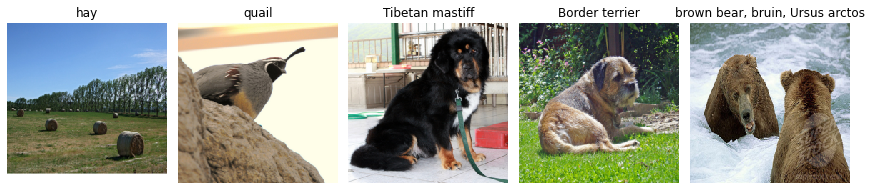

In [5]:
from cs7643.data_utils import load_imagenet_val
X, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

# Saliency Maps (2 pts)
Using this pretrained model, we will compute class saliency maps as described in the paper: 

[1] [Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.](https://arxiv.org/abs/1312.6034)

We will also review this paper in the paper presentation.

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(3, H, W)` then this gradient will also have shape `(3, H, W)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.


### Hint: PyTorch `gather` method
Recall when you need to select one element from each row of a matrix; if `s` is an numpy array of shape `(N, C)` and `y` is a numpy array of shape `(N,`) containing integers `0 <= y[i] < C`, then `s[np.arange(N), y]` is a numpy array of shape `(N,)` which selects one element from each element in `s` using the indices in `y`.

In PyTorch you can perform the same operation using the `gather()` method. If `s` is a PyTorch Tensor or Variable of shape `(N, C)` and `y` is a PyTorch Tensor or Variable of shape `(N,)` containing longs in the range `0 <= y[i] < C`, then

`s.gather(1, y.view(-1, 1)).squeeze()`

will be a PyTorch Tensor (or Variable) of shape `(N,)` containing one entry from each row of `s`, selected according to the indices in `y`.

run the following cell to see an example.

You can also read the documentation for [the gather method](http://pytorch.org/docs/torch.html#torch.gather)
and [the squeeze method](http://pytorch.org/docs/torch.html#torch.squeeze).

In [6]:
# Example of using gather to select one entry from each row in PyTorch
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(s.gather(1, y.view(1,-1)).squeeze())
gather_example()

tensor([[-0.6697, -0.7197,  0.9416, -0.9358,  0.8761],
        [ 0.4350,  0.7268, -0.5555, -1.2319,  1.1433],
        [-0.1490, -0.9435, -0.0895,  0.1957,  2.1989],
        [ 0.2762,  0.0518, -1.4562,  0.1008,  0.6743]])
tensor([-0.7197,  0.9416, -0.7197, -0.9358])


In [7]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y, requires_grad=False)
    saliency = None

    lam = 1e-3 # This is the regularization parameter when you need it
    
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    scores_all_classes = model(X_var)
    #pdb.set_trace()
    
    scores_correct_class = scores_all_classes.gather(1, y_var.view(-1, 1)).squeeze()
    
    loss = (scores_correct_class - lam*torch.sum(X_var*X_var, dim=(1,2,3))).sum()
    
    grads = torch.autograd.grad(loss, X_var)[0]

    saliency = grads.max(axis=1)[0]
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

Once you have completed the implementation in the cell above, run the following to visualize some class saliency maps on our example images from the ImageNet validation set. You can compare to the figure 2 in the refered paper as a comparison for your results.

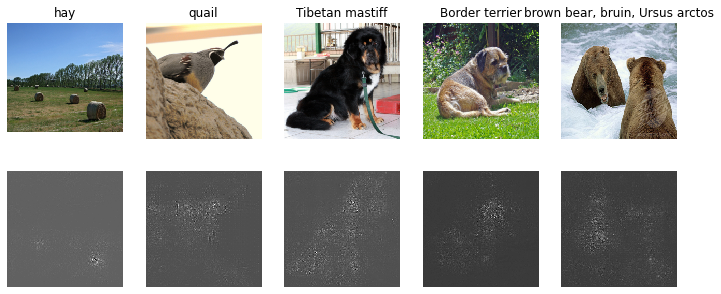

In [8]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()

    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.gray)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

## Captum (0.2 pt)

As a final step, we will show you how simple it is to use Saliency Maps using Captum instead. 

Captum offers a number of attribution algorithms for PyTorch models that are very easy to use. Let's apply those algorithms to our model and the five images that we loaded from imagenet.

We have created a generic helper visualization function that will allow you to visualize and compare the attributions of different algorithms next to each other for each image. (`compute_attributions` and `visualize_attr_maps`, found in the helper functions section)

Let's apply the saliency maps attribution algorithm on the images and observe how the attributions differ.

To do so we need to import those algorithms from the Captum library, create instances of the corresponding algorithms, call our compute_attribute function on these instances, and finally visualize using our helper function.

We have included an example of how we can apply a number of attribution algorithms on our model and images.

Feel free to try other algorithms and compare their results.

Please, be aware that some of the algorithms, such as perturbation algorithms, might take longer to execute and might have higher memory requirments. In case you run into OOM issues for integrated gradients you can try to reduce the number of integral approximation steps (n_steps) or set the value of internal_batch_size input argument to a small number. The value of `ablations_per_eval` or `perturbation_per_eval` can be adjusted also for all perturbation algorithms in order to reduce memory footprint. This might lead to a slower execution runtime, however it will help to avoid OOM.

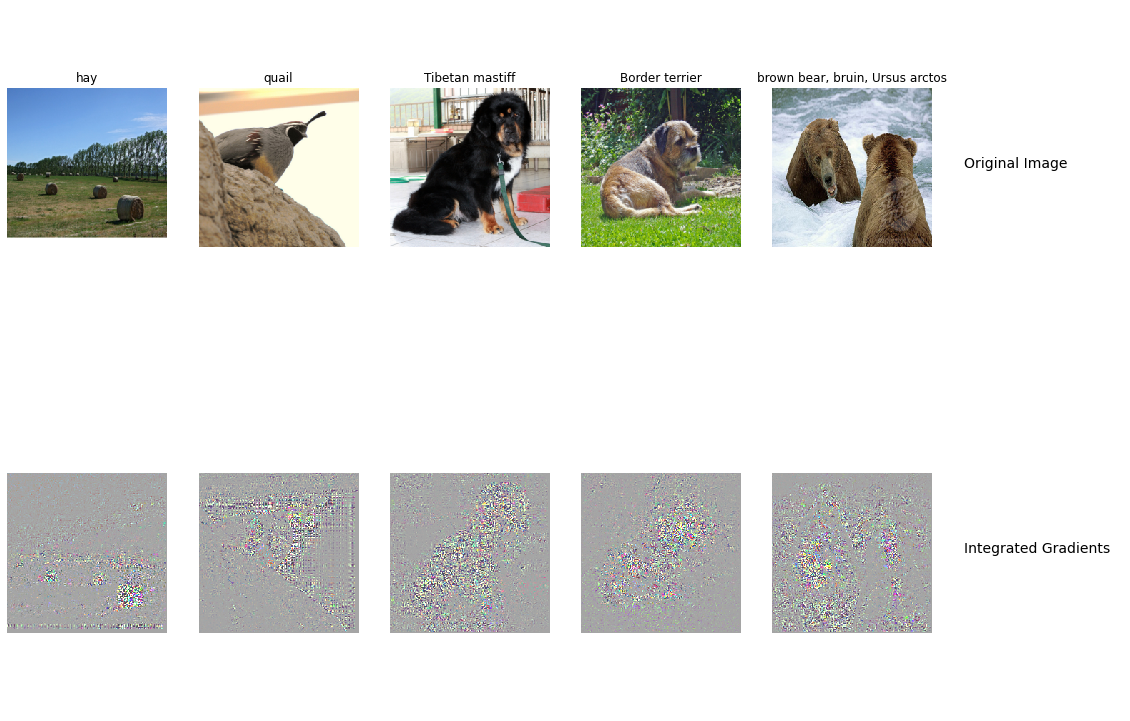

c:\georgia tech\dl - cs 4803\hw3\captum\captum\_utils\gradient.py:38: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


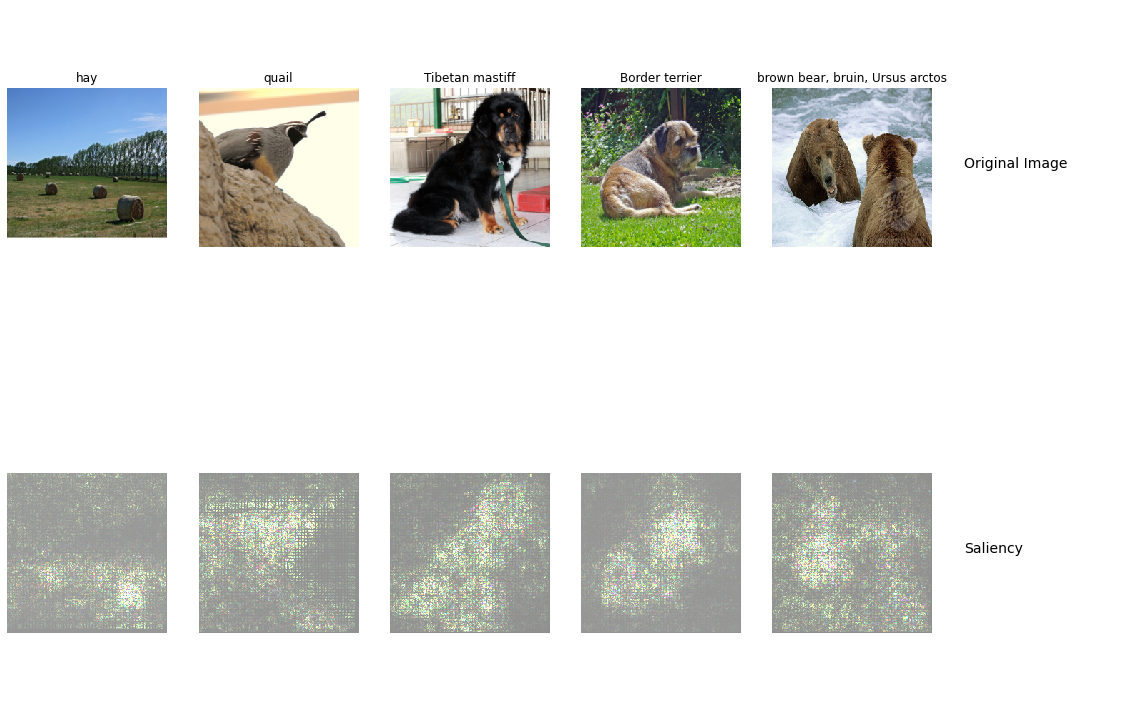

In [9]:
from captum.attr import IntegratedGradients, Saliency

    
# Convert X and y from numpy arrays to Torch Tensors
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
y_tensor = torch.LongTensor(y)


# Computing Integrated Gradient
int_grads = IntegratedGradients(model)
attr_ig = compute_attributions(int_grads, X_tensor, target=y_tensor, n_steps=10)
visualize_attr_maps([attr_ig], ['Integrated Gradients'])
##############################################################################
# TODO: Compute/Visualize Saliency using captum.                             #
##############################################################################
saliency = Saliency(model)
saliency_attr_ig = compute_attributions(saliency, X_tensor, target=y_tensor)
visualize_attr_maps([saliency_attr_ig], ['Saliency'])
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

# GradCAM (3 pts)

GradCAM (which stands for Gradient Class Activation Mapping) is a technique that tells us where a convolutional network is looking when it is making a decision on a given input image. There are three main stages to it:

* __Guided Backprop (Changing ReLU Backprop Layer, https://arxiv.org/abs/1412.6806)__
* __GradCAM (Manipulating gradients at the last convolutional layer, https://arxiv.org/abs/1610.02391)__
* __Guided GradCAM (Pointwise multiplication of above stages)__

In this section, you will be implementing these three stages to recreate the full GradCAM pipeline. At each stage, you can visualize what the current output is to see exactly what is happening.

We begin with Guided Backprop. We encourage you to read the paper above first, to gain an understanding of what Guided Backprop is trying to do. From the paper, we have that:
* The ’deconvolution’ is equivalent to a backward pass through the network, except that when propagating through a nonlinearity, its gradient is solely computed based on the top gradient signal, ignoring the bottom input. In case of the ReLU nonlinearity this amounts to setting to zero certain entries based on the top gradient. We propose to combine these two methods: rather than masking out values corresponding to negative entries of the top gradient (’deconvnet’) or bottom data (backpropagation), we mask out the values for which at least one of these values is negative.

In [10]:
# FOR THIS SECTION ONLY, we need to use gradients. We introduce a new model we will use explicitly for GradCAM for this.
gc_model = torchvision.models.squeezenet1_1(pretrained=True)
for param in gc_model.parameters():
    param.requires_grad = True

In [11]:
class CustomReLU(TorchFunc):
    """
    Define the custom change to the standard ReLU function necessary to perform guided backpropagation. 
    We have already implemented the forward pass for you, as this is the same as a normal ReLU function.
    """
    
    @staticmethod
    def forward(self, x):
        output = torch.addcmul(torch.zeros(x.size()), x, (x > 0).type_as(x))
        self.save_for_backward(x, output)
        return output

    @staticmethod
    def backward(self, y):
        ##############################################################################
        # TODO: Implement this function. Perform a backwards pass as described in    #
        # paper above. Note: torch.addcmul might be useful, and you can access       #
        # the input/output from the forward pass with self.saved_tensors.            #
        ##############################################################################
        inputs  = self.saved_tensors[0]
        outputs = self.saved_tensors[1]
        dx = torch.addcmul(torch.zeros(y.size()), y, (inputs>0).type_as(inputs))
        dx = torch.addcmul(torch.zeros(dx.size()), dx, (outputs>0).type_as(outputs))
        return dx
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

To test your implementation, run the code below.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


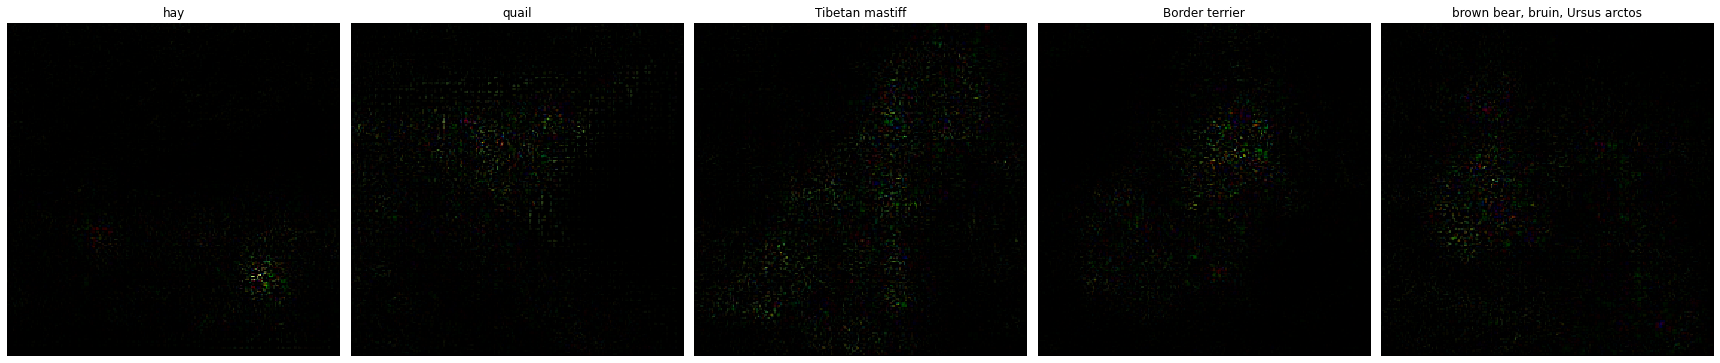

In [12]:
for idx, module in gc_model.features._modules.items():
    if module.__class__.__name__ == 'ReLU':
        gc_model.features._modules[idx] = CustomReLU.apply

def guided_backprop(X_tensor,y_tensor):
    ##############################################################################
    # TODO: Implement guided backprop as described in paper.                     #
    # (Hint): Now that you have implemented the custom ReLU function, this       #
    # method will be similar to a single training iteration.                     #
    ##############################################################################
    scores_all_classes = gc_model(X_tensor)
    
    scores_correct_class = scores_all_classes.gather(1, y_tensor.view(-1, 1)).squeeze()
    
    loss = (scores_correct_class).sum()
    
    grads = torch.autograd.grad(loss, X_tensor)[0]
    
    return grads.permute(0,2,3,1).detach().numpy()
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0).requires_grad_(True)
y_tensor = torch.LongTensor(y)
gbp_result = guided_backprop(X_tensor,y_tensor)

plt.figure(figsize=(24, 24))
for i in range(gbp_result.shape[0]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(gbp_result[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

Next, we can implement GradCAM. We have given you which module(=layer) that we need to capture gradients from, which you can see in `conv_module` variable below - feel free to play around with this to see visualizations for different layers, but in your final submission keep it to what we gave you. We have already provided a gradient and activation hook for you, and the gradient value of the module you choose will be stored in the `gradient_value` variable (similarly `activation_value` will hold the layer activation). The rest of the implementation of GradCAM is up to you. 

In [13]:
# Reset model from any changes made during Guided Backprop
gc_model = torchvision.models.squeezenet1_1(pretrained=True)
for param in gc_model.parameters():
    param.requires_grad = True

In [14]:
conv_module = gc_model.features[12]

gradient_value = None # Stores gradient of the module you chose above during a backwards pass.
activation_value = None # Stores the activation of the module you chose above during a forwards pass.

def gradient_hook(a,b,gradient):
    global gradient_value
    gradient_value = gradient[0]
    
def activation_hook(a,b,activation):
    global activation_value
    activation_value = activation

conv_module.register_forward_hook(activation_hook)
conv_module.register_backward_hook(gradient_hook)

In [15]:
def grad_cam(X_tensor, y_tensor):
    ##############################################################################
    # TODO: Implement GradCam as described in paper.                             #
    ##############################################################################
    
    scores_all_classes = gc_model(X_tensor)
    scores_correct_class = scores_all_classes.gather(1, y_tensor.view(-1, 1)).squeeze()
    loss = (scores_correct_class).sum()
    grads = torch.autograd.grad(loss, X_tensor)[0]
        
    Z = gradient_value.shape[2]*gradient_value.shape[3]
    weights = torch.sum(activation_value, dim=(2,3))/Z
    heat_map = torch.sum(weights[:,:,np.newaxis,np.newaxis]*activation_value, dim=1)
    relu = torch.nn.ReLU()
    cam = relu(heat_map).detach().numpy()
    
    
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    
    # Rescale GradCam output to fit image.
    cam_scaled = []
    for i in range(cam.shape[0]):
        cam_scaled.append(np.array(Image.fromarray(cam[i]).resize(X_tensor[i,0,:,:].shape)))
    cam = np.array(cam_scaled)
    cam -= np.min(cam)
    cam /= np.max(cam)
    return cam

To test your implementation, run the code below.

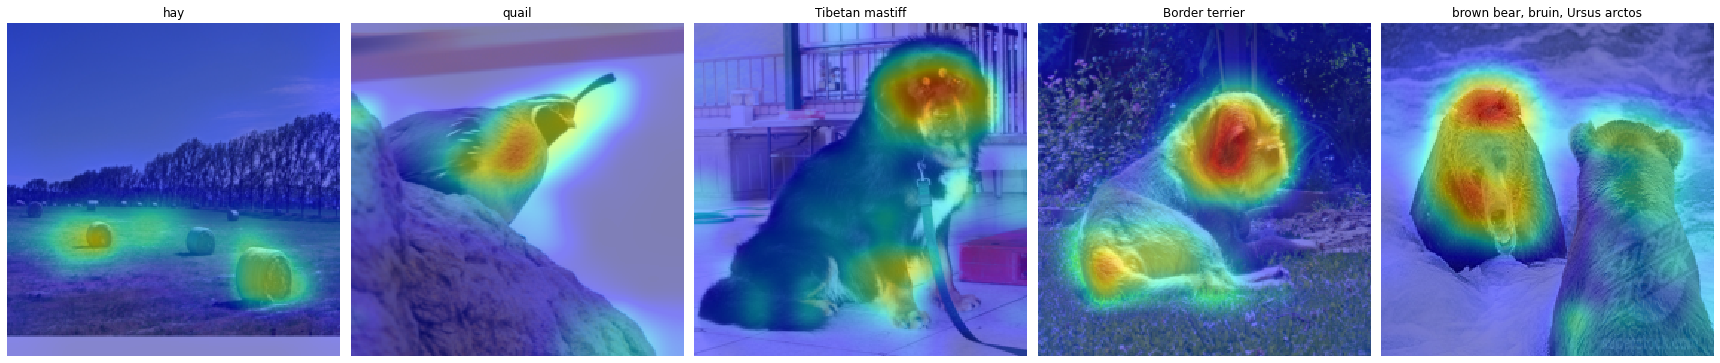

In [16]:
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0).requires_grad_(True)
y_tensor = torch.LongTensor(y)
gradcam_result = grad_cam(X_tensor, y_tensor)

plt.figure(figsize=(24, 24))
for i in range(gradcam_result.shape[0]):
    gradcam_val = gradcam_result[i]
    img = X[i] + (matplotlib.cm.jet(gradcam_val)[:,:,:3]*255)
    img = img / np.max(img)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

As a final step, we can combine GradCam and Guided Backprop to get Guided GradCam.

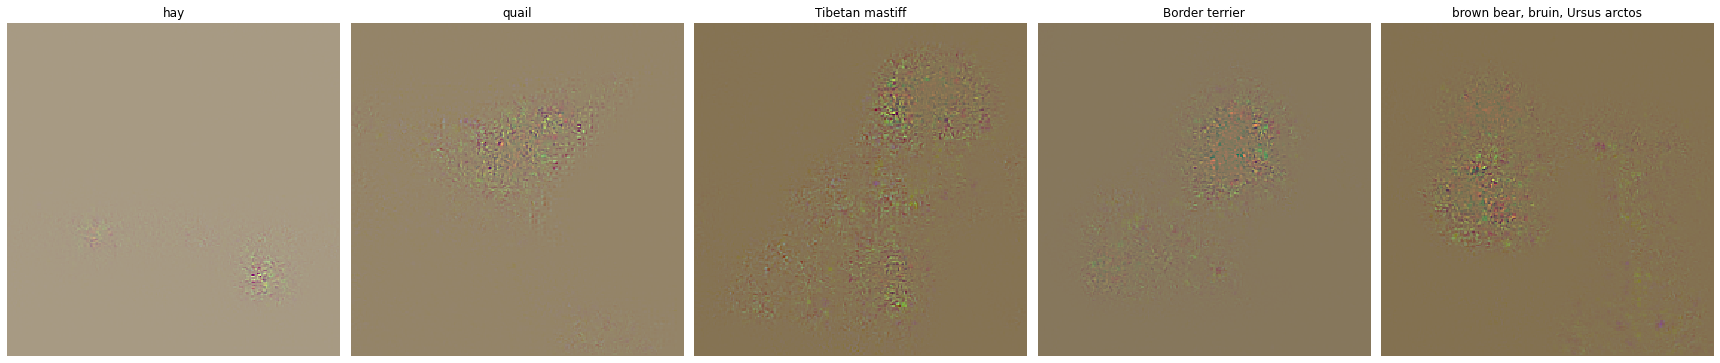

In [17]:
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0).requires_grad_(True)
y_tensor = torch.LongTensor(y)
gradcam_result = grad_cam(X_tensor, y_tensor)
gbp_result = guided_backprop(X_tensor,y_tensor)

plt.figure(figsize=(24, 24))
for i in range(gradcam_result.shape[0]):
    gbp_val = gbp_result[i]
    gbp_val /= np.max(gbp_val)
    gradcam_val = (matplotlib.cm.jet(gradcam_result[i])[:,:,:3]*255)
    
    ##############################################################################
    # TODO: Pointwise multiplication and normalization of the gradcam and guided #
    #       backprop results (2 lines)                                           #
    ##############################################################################
    img = gbp_val * gradcam_val
    img /= np.max(img)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    
    img = np.expand_dims(img.transpose(2,0,1),axis=0)
    img = np.float32(img)
    img = torch.from_numpy(img)
    img = deprocess(img)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

## Captum (0.4 pt)

As a final step, implement GradCam and GuidedBackprop exactly as you did for saliency maps above and compare your visualizations with the ones using Captum (note: **These visualization will look significantly different, as Captum has different pre/post processing steps for images**).

c:\georgia tech\dl - cs 4803\hw3\captum\captum\attr\_core\guided_backprop_deconvnet.py:59: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


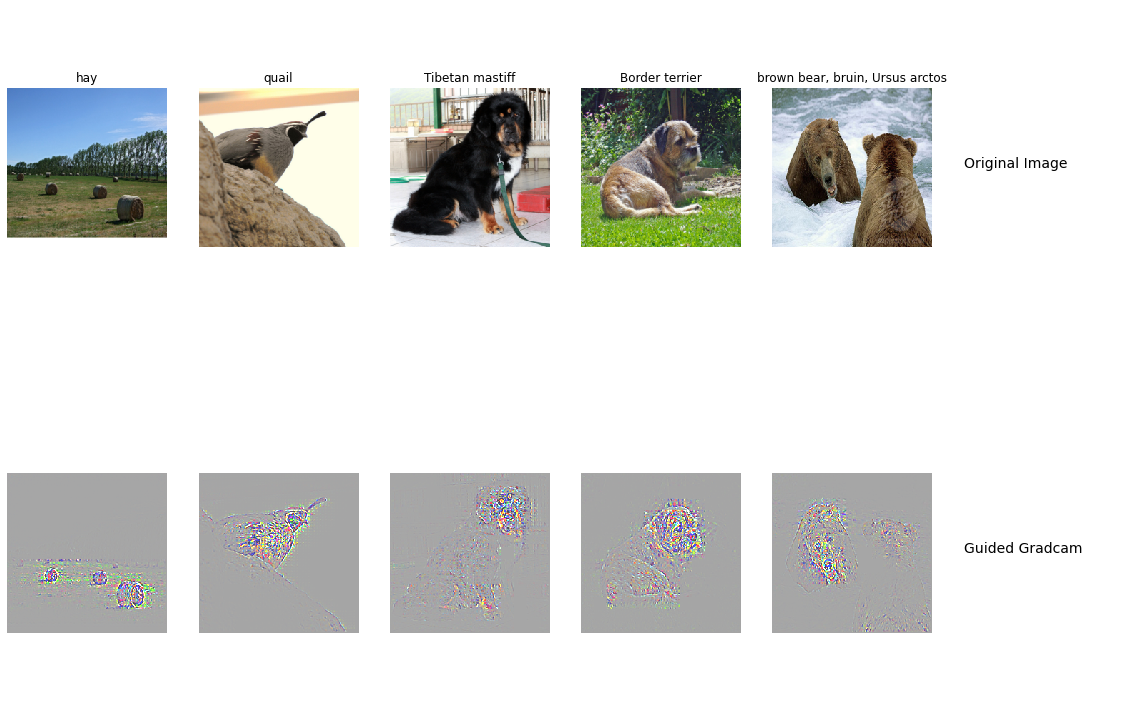

In [18]:
from captum.attr import GuidedGradCam, GuidedBackprop

    
# Convert X and y from numpy arrays to Torch Tensors
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
y_tensor = torch.LongTensor(y)

##############################################################################
# TODO: Compute/Visualize GuidedBackprop and GradCAM as well.                #
##############################################################################
guided_gc = GuidedGradCam(gc_model, conv_module)
guided_gc_attr_ig = compute_attributions(guided_gc, X_tensor, target=y_tensor)
visualize_attr_maps([guided_gc_attr_ig], ['Guided Gradcam'])
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

## Visualizaing layers and neurons using Captum (0.4 pts)

Let's try to attribute to a selected layer and visualize the attribution for any selected channel.
We can choose to change the layers and channels and observe how the attribution changes.

Consider also using https://captum.ai/api/_modules/captum/attr/_utils/attribution.html#LayerAttribution.interpolate to interpolate layer dimensions to given input dimensions.

Please, be aware of the memory limitation and how you can overcome those using the techinques described in the previous section.

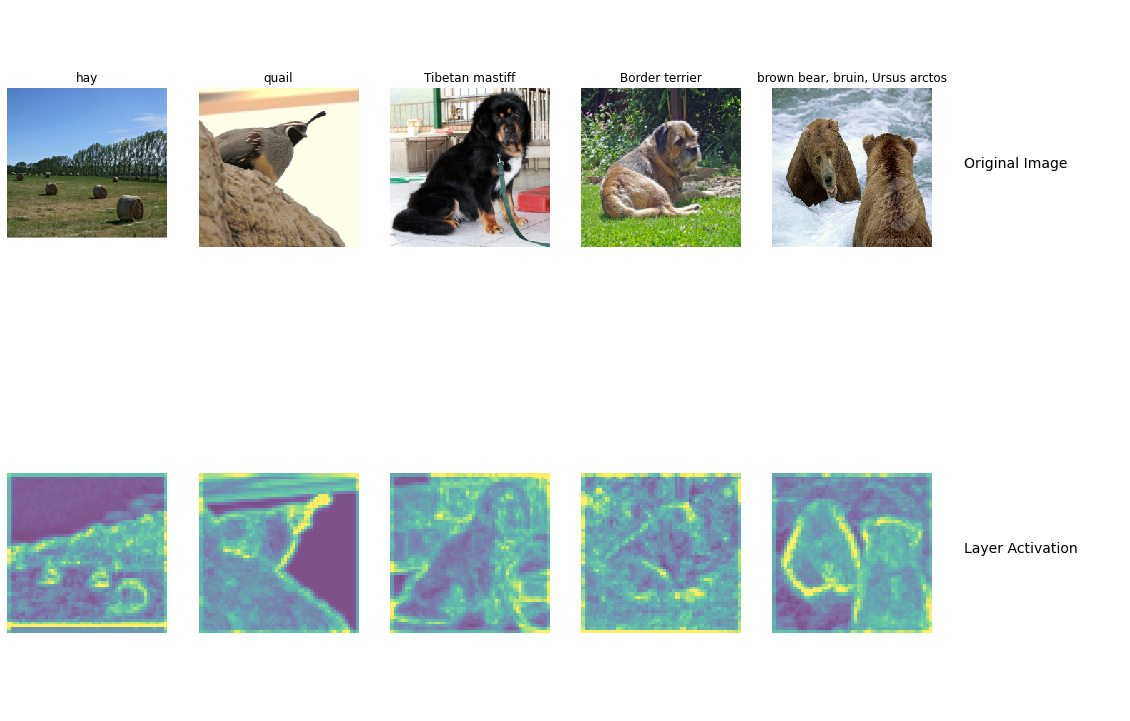

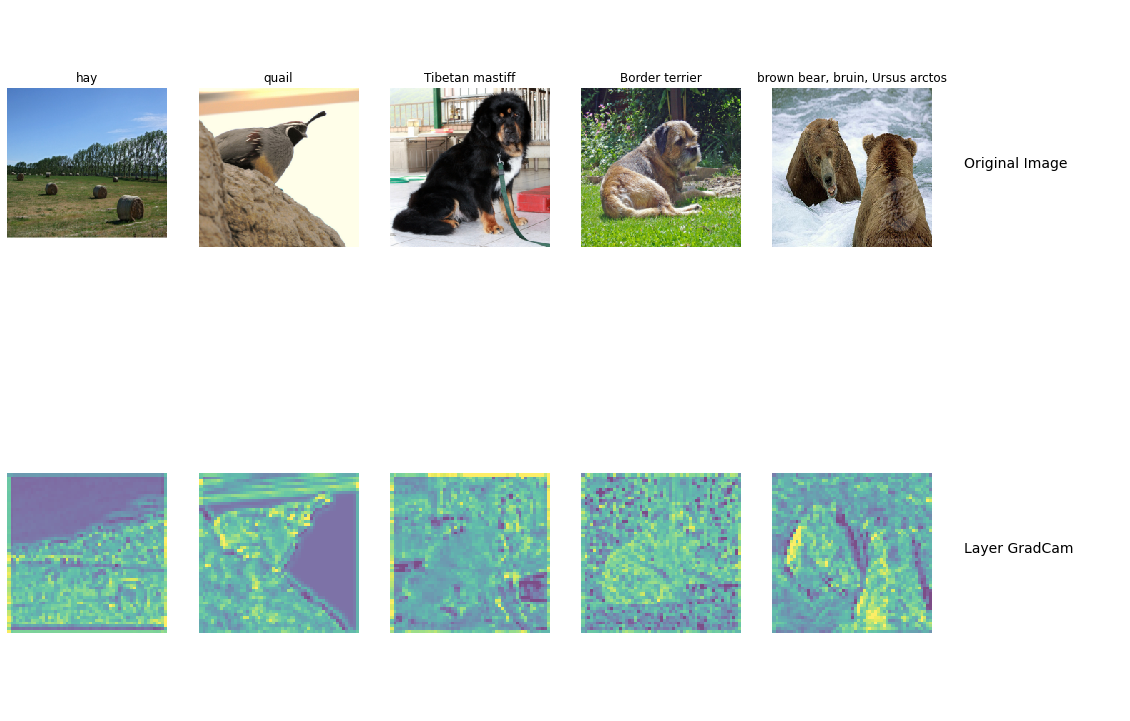

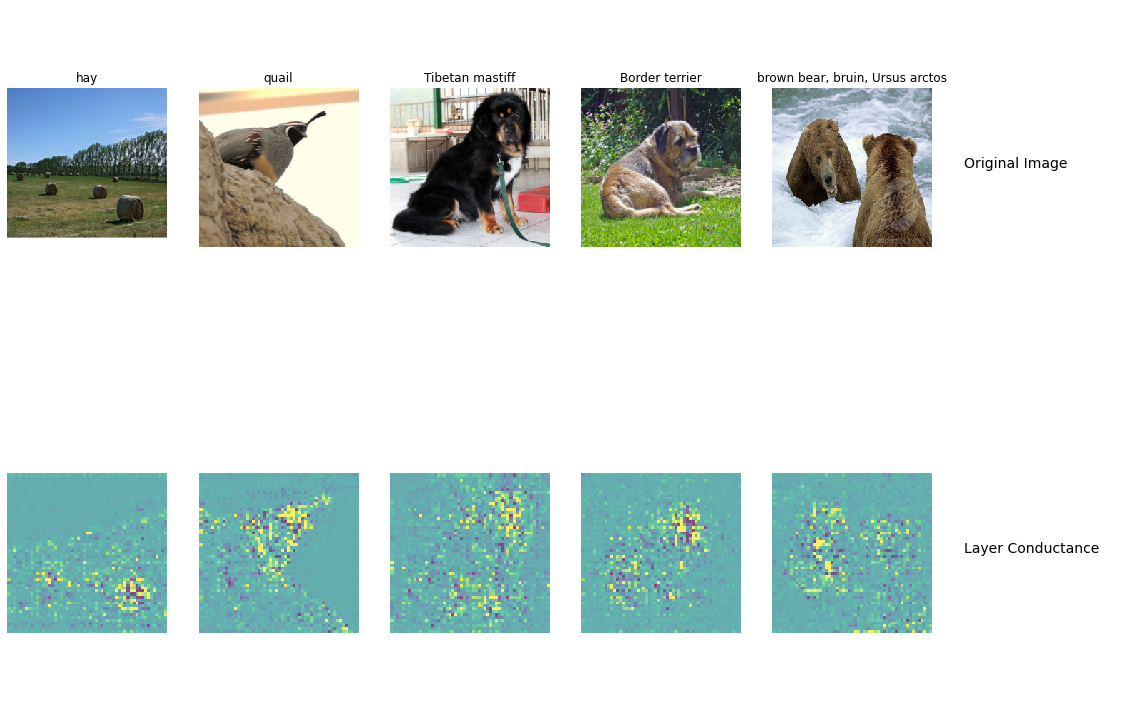

In [19]:
from captum.attr import LayerActivation, LayerConductance, LayerGradCam

# Try out different layers and see observe how the attributions change
layer = model.features[4]

layer_act = LayerActivation(model, layer)
layer_act_attr = compute_attributions(layer_act, X_tensor)
layer_act_attr_sum = layer_act_attr.mean(axis=1, keepdim=True)
##############################################################################
# TODO: Visualize Individual Layer Gradcam and Layer Conductance (similar    #
# to what we did for the other captum sections, using our helper methods),   #
# but with some preprocessing calculations.                                  #
##############################################################################
attr = layer_act.interpolate(layer_attribution = layer_act_attr_sum, interpolate_dims = X.shape[1:3])
visualize_attr_maps([attr], ['Layer Activation'])

layer_grad_cam = LayerGradCam(model, layer)
layer_grad_cam_attr = compute_attributions(layer_grad_cam, X_tensor, target=y_tensor)
layer_conduct_attr_sum = layer_grad_cam_attr.mean(axis=1, keepdim=True)
grad_cam_attr = layer_act.interpolate(layer_attribution = layer_conduct_attr_sum, interpolate_dims = X.shape[1:3])
visualize_attr_maps([grad_cam_attr], ['Layer GradCam'])

layer_conduct = LayerConductance(model, layer)
layer_conduct_attr = compute_attributions(layer_conduct, X_tensor, target=y_tensor)
layer_conduct_attr_sum = layer_conduct_attr.mean(axis=1, keepdim=True)
conductance_attr = layer_act.interpolate(layer_attribution = layer_conduct_attr_sum, interpolate_dims = X.shape[1:3])
visualize_attr_maps([conductance_attr], ['Layer Conductance'])

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

# Fooling Images (2 pts)

We can also use the similar concept of image gradients to study the stability of the network. Consider a state-of-the-art deep neural network that generalizes well on an object recognition task. We expect such network to be robust to small perturbations of its input, because small perturbation cannot change the object category of an image. However, [2] find that applying an imperceptible non-random perturbation to a test image, it is possible to arbitrarily change the network’s prediction.

[2] [Szegedy et al, "Intriguing properties of neural networks", ICLR 2014](https://arxiv.org/abs/1312.6199)

Given an image and a target class, we can perform **gradient ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. We term the so perturbed examples “adversarial examples”. 

**Read the paper, and then implement the following function to generate fooling images.**


In [20]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    
    model.eval()
    
    # Initialize our fooling image to the input image, and wrap it in a Variable.
    X_fooling = X.clone()
    X_fooling_var = Variable(X_fooling, requires_grad=True)
    
    # We will fix these parameters for everyone so that there will be 
    # comparable outputs
    
    learning_rate = 10 # learning rate is 1
    max_iter = 100 # maximum number of iterations
    
    for it in range(max_iter):
        
    ##############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. You should perform gradient ascent on the score of the #
    # target class, stopping when the model is fooled.                           #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * g / ||g||_2                                         #
    #                                                                            #
    # Inside of this loop, write the update rule.                                #
    #                                                                            #
    # HINT:                                                                      #
    # You can print your progress (current prediction and its confidence score)  #
    # over iterations to check your gradient ascent progress.                    #
    ############################################################################## 
        scores_all_classes = gc_model(X_fooling_var)
        scores_correct_class = scores_all_classes[0,target_y]
        loss = scores_correct_class

        grads = torch.autograd.grad(loss, X_fooling_var)[0]
        
        dX = learning_rate * grads/torch.sum(grads*grads)
        
        X_fooling_var = X_fooling_var.clone() + dX
        if it%10 ==0:
            print('iter: ', it, ' loss: ', loss)
    
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    
    X_fooling = X_fooling_var.data
    
    return X_fooling

Now you can run the following cell to **generate a fooling image**. You will see the message 'Fooled the model' when you succeed. 

In [21]:
idx = 0
target_y = 6 # target label. Change to a different label to see the difference.

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(Variable(X_fooling))

if target_y == scores.data.max(1)[1][0]: 
    print('Fooled the model!')
else:
    print('The model is not fooled!')


iter:  0  loss:  tensor(6.1461, grad_fn=<SelectBackward>)
iter:  10  loss:  tensor(36.9136, grad_fn=<SelectBackward>)
iter:  20  loss:  tensor(63.2085, grad_fn=<SelectBackward>)
iter:  30  loss:  tensor(79.8750, grad_fn=<SelectBackward>)
iter:  40  loss:  tensor(88.6994, grad_fn=<SelectBackward>)
iter:  50  loss:  tensor(100.7683, grad_fn=<SelectBackward>)
iter:  60  loss:  tensor(105.8299, grad_fn=<SelectBackward>)
iter:  70  loss:  tensor(121.8978, grad_fn=<SelectBackward>)
iter:  80  loss:  tensor(126.0166, grad_fn=<SelectBackward>)
iter:  90  loss:  tensor(131.5731, grad_fn=<SelectBackward>)
Fooled the model!


After generating a fooling image, run the following cell to visualize the original image, the fooling image, as well as the difference between them.

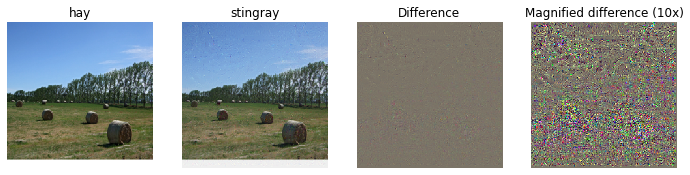

In [22]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

# Class visualization (3 pts)

By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [1]; [3] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = \arg\max_I s_y(I) - R(I)
$$

where $R$ is a (possibly implicit) regularizer (note the sign of $R(I)$ in the argmax: we want to minimize this regularization term). We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) = \lambda \|I\|_2^2
$$

**and** implicit regularization as suggested by [3] by periodically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

[1] [Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014](https://arxiv.org/abs/1312.6034)

[3] [Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop](http://yosinski.com/media/papers/Yosinski__2015__ICML_DL__Understanding_Neural_Networks_Through_Deep_Visualization__.pdf)

**In the cell below, complete the implementation of the `create_class_visualization` function.**


In [23]:
def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

In [24]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
        
    model.eval()
    
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and also wrap it in
    # a PyTorch Variable.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype)
    img_var = Variable(img, requires_grad=True)

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.copy_(jitter(img, ox, oy))

        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        reg = l2_reg * torch.sum(img_var*img_var)
        
        scores = model(img_var)
        scores_correct_class = scores[0,target_y]
        loss = scores_correct_class - reg

        grad = torch.autograd.grad(loss, img_var)[0]
                
        img_var = img_var.clone() + learning_rate * grad
        
        img = img_var.detach()

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        
        # Undo the random jitter
        img.copy_(jitter(img, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
    return deprocess(img.cpu())

Once you have completed the implementation in the cell above, run the following cell to generate images of several classes. Show the generated images when you submitted your notebook. 

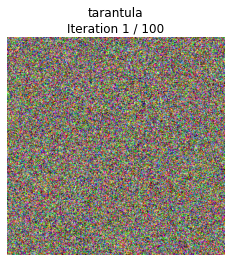

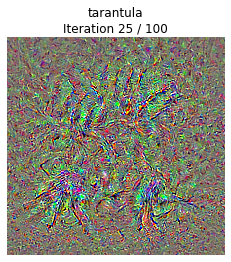

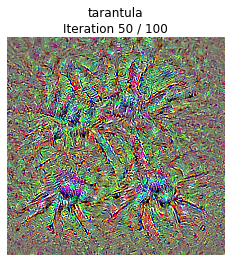

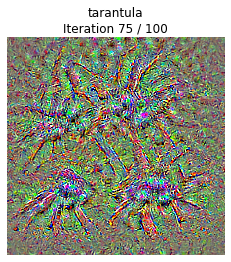

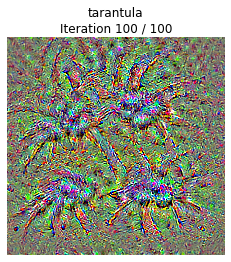

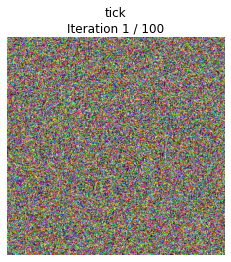

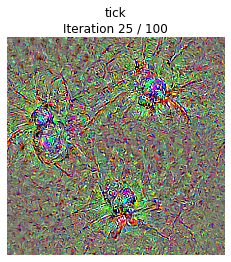

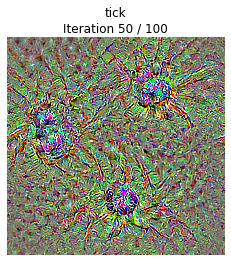

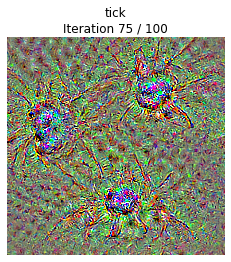

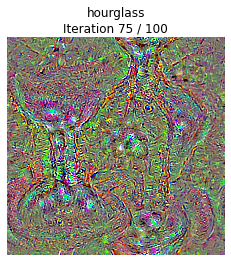

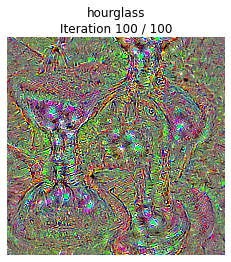

In [25]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model.type(dtype)

# You can use a single class during your debugging session, 
# but please show all the generated outputs in your submitted notebook

# target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass

targets = [76, 78, 187, 683, 366, 604]

for target in targets:
    out = create_class_visualization(target, model, dtype)

Try out your class visualization on other classes! You should also feel free to play with various hyperparameters to try and improve the quality of the generated image, but this is not required.

forklift


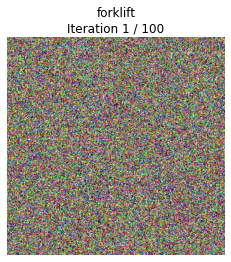

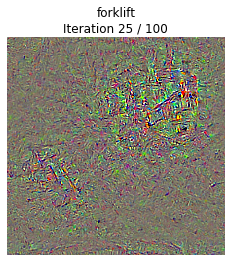

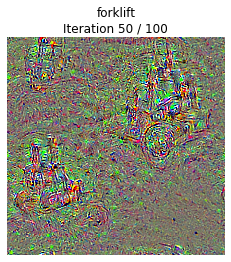

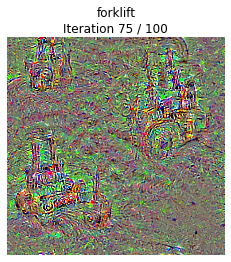

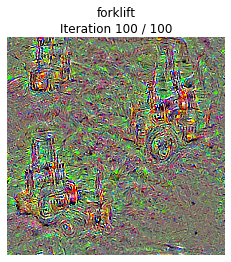

In [29]:
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
target_y = np.random.randint(1000)
print(class_names[target_y])
X = create_class_visualization(target_y, model, dtype)